In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-machine-learning-from-disaster/__results__.html
/kaggle/input/titanic-machine-learning-from-disaster/submission.csv
/kaggle/input/titanic-machine-learning-from-disaster/__notebook__.ipynb
/kaggle/input/titanic-machine-learning-from-disaster/__output__.json
/kaggle/input/titanic-machine-learning-from-disaster/custom.css
/kaggle/input/titanic-machine-learning-from-disaster/__results___files/__results___10_0.png
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
history = []
y_full_data = train_data['Survived']
drop_col = ['Cabin','PassengerId','Ticket','Fare']
X_full_data = train_data.drop(columns=drop_col + ['Survived'])
X_full_data.head()
#X_full_data[['Last','First']] = X_full_data.Name.str.split(',',expand=True)
#X_full_data.drop(columns='Name', inplace=True)
#X_full_data[['a','b','c']] = X_full_data.First.str.split(pat="[a-z].",expand=True)
#c= X_full_data.First.str.split('.',expand=True)
#X_full_data.head()
#c.head()
#X_full_data.First
#c.index
#c.drop(columns='2',inplace=True)

,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,S


In [6]:
def modify_dataset(df: pd.DataFrame):
    df_c = df.copy()
    
    family_col = ['SibSp', 'Parch']
    df_c['Family'] = df[family_col].sum(axis=1)
    df_c.drop(columns=family_col, inplace=True)

    df_c[['Last','FirstName']] = df.Name.str.split(',',expand=True)
    df_c.drop(columns=['Name','FirstName'],inplace=True)
    #df_c[['Title','FirstName']] = df_c.FirstName.str.split(pat='.',expand=True)
    return df_c

In [7]:
f_X_full_data = modify_dataset(X_full_data)
f_X_full_data.head()
f_X_full_data.isna().sum()
#f_X_full_data['Pclass'].unique(), f_X_full_data.shape

Pclass        0
Sex           0
Age         177
Embarked      2
Family        0
Last          0
dtype: int64

In [8]:
feature_num = f_X_full_data.select_dtypes('number').columns
feature_num = ['Family','Age']
print('Feature Num : ', feature_num)
feature_ordinal=['Sex','Embarked','Pclass']
feature_hotencoder=['Last']

numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='-1')),
    ('encoder', OrdinalEncoder()),
])
hotencoder_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False)),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, feature_num),
    ('hotencoder',hotencoder_transformer,feature_hotencoder ),
    ('ordinal', ordinal_transformer,feature_ordinal)
])

#X_train, X_valid, y_train, y_valid = train_test_split(X_full_data,y_full_data,random_state=1, test_size=0.8)
p_f_X_full_data = preprocessor.fit_transform(f_X_full_data,y_full_data)
df_p_f_X_full_data = pd.DataFrame(p_f_X_full_data)
#df_p_X_full_data.head()
df_p_f_X_full_data.head()

Feature Num :  ['Family', 'Age']


,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.1,0.271174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0
1,0.1,0.472229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.321438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
3,0.1,0.434531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,0.0,0.434531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0


In [9]:
def score_dataset(X_train,y_train, n_estimators, max_depth, random_state):
    
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                   random_state=random_state, 
                                   max_depth=max_depth)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train,y_train)
    mean = cross_val_score(pipeline, X_train, y_train,cv=5).mean()
    print('Depth : {}, Estimator : {}, Mean : {}'.format(depth,n_estimators, mean))
    return mean

In [10]:
histories = []
first_step = 50
step = 5
range_iter = 50
for depth in range(first_step, range_iter + 1, step):
    history = [(n_estimator, score_dataset(f_X_full_data, y_full_data, n_estimator, depth ,1)) 
             for n_estimator in range(100, 101,1)]
    
    histories.append((depth,history))
    print('[{}/{}]'.format(depth / step, range_iter/step))

Depth : 50, Estimator : 100, Mean : 0.8316615403929447
[10.0/10.0]


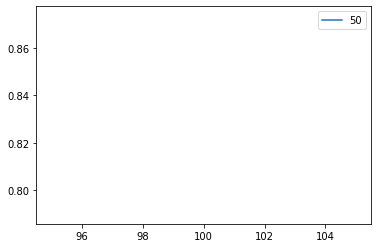

In [11]:
for depth , history in histories:
    x , y = zip(*history)
    plt.plot(x,y, label=depth)

plt.legend()
plt.show()

In [12]:
histories

[(50, [(100, 0.8316615403929447)])]

In [13]:
def updateSubmission(model, X_test):
    predictions = model.predict(X_test)

    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
    output.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")

In [14]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()
X_test=  test_data.drop(columns=drop_col)
f_X_test = modify_dataset(X_test)

model = RandomForestClassifier(n_estimators=105, 
                                   random_state=1, 
                                   max_depth=50)
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

pipeline.fit(f_X_full_data,y_full_data)
p_f_X_test = preprocessor.transform(f_X_test)
updateSubmission(model, p_f_X_test)
X_test.head()
f_X_test

Your submission was successfully saved!


,Pclass,Sex,Age,Embarked,Family,Last
0,3,male,34.5,Q,0,Kelly
1,3,female,47.0,S,1,Wilkes
2,2,male,62.0,Q,0,Myles
3,3,male,27.0,S,0,Wirz
4,3,female,22.0,S,2,Hirvonen
...,...,...,...,...,...,...
413,3,male,NaN,S,0,Spector
414,1,female,39.0,C,0,Oliva y Ocana
415,3,male,38.5,S,0,Saether
416,3,male,NaN,S,0,Ware


In [15]:
submission = pd.read_csv('submission.csv')
submission.head(), submission.shape

(   PassengerId  Survived
 0          892         0
 1          893         0
 2          894         0
 3          895         0
 4          896         1,
 (418, 2))